In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

import category_encoders
import missingno
import boruta
import tsfresh
import sktime
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import shap
import re
import imblearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc,
    precision_recall_curve,
    fbeta_score,
    cohen_kappa_score,
    make_scorer
)

In [ ]:
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Input, Sequential, Model
from imblearn.pipeline import Pipeline as ImbPipeline
from types import SimpleNamespace
import keras_tuner as kt

In [11]:
features_wide = pd.read_csv("C:/Users/u840716/Anna Thesis/Code Files -/Models/ML_models/summary_features_wide_final_2.csv")


## Evaluation function

In [12]:
def evaluate_model(model, X_test, y_test, model_name="Model", save_fig=False):
    # Predict
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # Basic Metrics
    cm = confusion_matrix(y_test, y_pred)
    f2 = fbeta_score(y_test, y_pred, beta=2)
    kappa = cohen_kappa_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print(f"Evaluation for {model_name}")
    print("-" * 40)
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print(f"F2 Score: {f2:.4f}")
    print(f"Cohen’s Kappa: {kappa:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print("-" * 40)

    # Plotting
    plt.figure(figsize=(18, 5))

    # Confusion Matrix
    plt.subplot(1, 3, 1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"])
    plt.yticks(ticks=[0.5, 1.5], labels=["Control (0)", "VT (1)"], rotation=0)

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.subplot(1, 3, 2)
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()

    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.subplot(1, 3, 3)
    plt.plot(recall, precision, label=f"AUC = {pr_auc:.2f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()

    plt.tight_layout()
    if save_fig:
        plt.savefig(f"{model_name.replace(' ', '_')}_evaluation.pdf", format="pdf", bbox_inches="tight")
    plt.show()

In [13]:
# Split features and labels
X = features_wide.drop(columns=["PatID", "Patient_Type"])
y = features_wide["Patient_Type"]


In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


# Split by class
X_vt_train = X_train[y_train == 1]
X_control_train = X_train[y_train == 0]
X_vt_test = X_test[y_test == 1]
X_control_test = X_test[y_test == 0]

In [16]:
def build_mlp(input_dim):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model



# Imputation

In [24]:
def impute_and_evaluate_mlp(imputer_vt, imputer_control, name):
    # Impute train
    X_vt_train_imputed = pd.DataFrame(imputer_vt.fit_transform(X_vt_train), columns=X.columns)
    X_control_train_imputed = pd.DataFrame(imputer_control.fit_transform(X_control_train), columns=X.columns)
    X_train_final = pd.concat([X_vt_train_imputed, X_control_train_imputed])
    y_train_final = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

    # Impute test
    X_vt_test_imputed = pd.DataFrame(imputer_vt.transform(X_vt_test), columns=X.columns)
    X_control_test_imputed = pd.DataFrame(imputer_control.transform(X_control_test), columns=X.columns)
    X_test_final = pd.concat([X_vt_test_imputed, X_control_test_imputed])
    y_test_final = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])

    # Shuffle training data
    X_train_final, y_train_final = shuffle(X_train_final, y_train_final, random_state=42)

    # Scale
    scaler = StandardScaler().fit(X_train_final)
    X_train_scaled = scaler.transform(X_train_final)
    X_test_scaled = scaler.transform(X_test_final)

    # Train MLP
    model = build_mlp(X_train_scaled.shape[1])
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train_scaled, y_train_final,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        callbacks=[es],
        verbose=0
    )

    # Attach sklearn-style methods
    orig_predict = model.predict
    def predict_proba(X_input):
        p1 = orig_predict(X_input).ravel()
        return np.vstack([1 - p1, p1]).T
    def predict(X_input):
        return (predict_proba(X_input)[:, 1] > 0.5).astype(int)
    model.predict_proba = predict_proba
    model.predict = predict

    # Evaluate
    evaluate_model(model, X_test_scaled, y_test_final, model_name=f"MLP - {name} Imputation (per class)")


c:\Users\u840716\Anna Thesis\venv310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation for MLP - Mean Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97       397
           1       0.71      0.17      0.28        29

    accuracy                           0.94       426
   macro avg       0.83      0.58      0.62       426
weighted avg       0.93      0.94      0.92       426

F2 Score: 0.2033
Cohen’s Kappa: 0.2581
ROC AUC Score: 0.8265
----------------------------------------


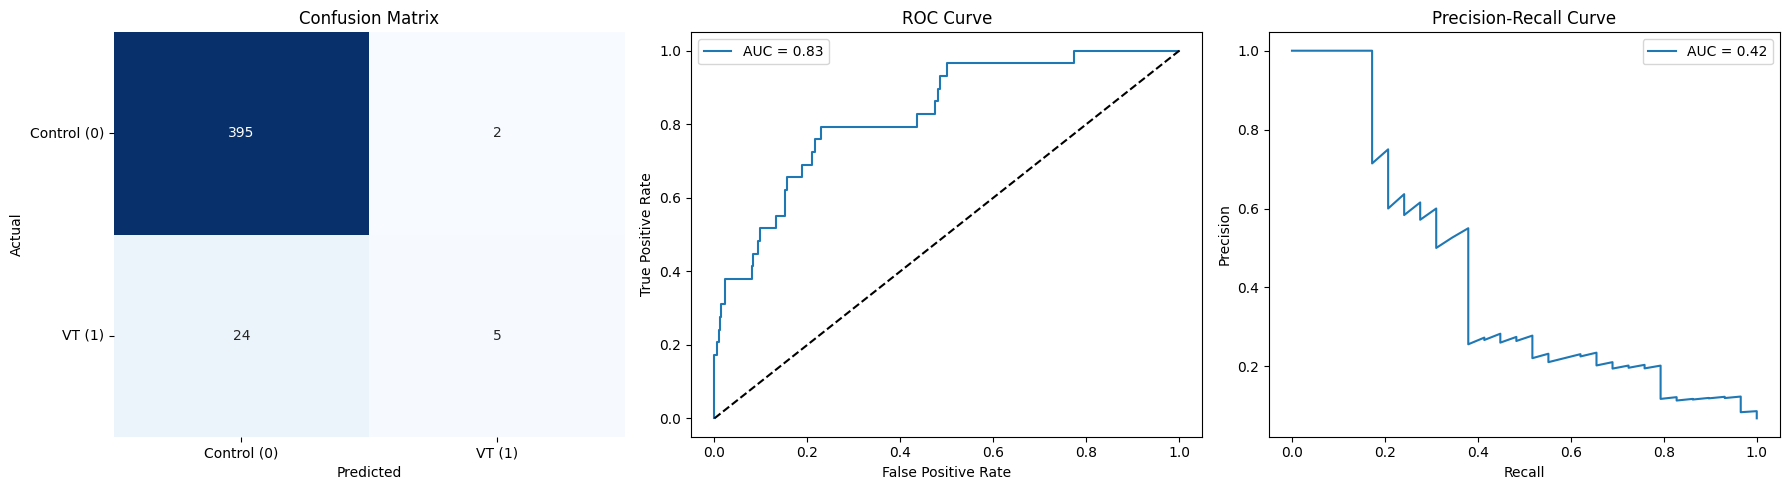

c:\Users\u840716\Anna Thesis\venv310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Evaluation for MLP - Median Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       397
           1       0.53      0.28      0.36        29

    accuracy                           0.93       426
   macro avg       0.74      0.63      0.66       426
weighted avg       0.92      0.93      0.92       426

F2 Score: 0.3053
Cohen’s Kappa: 0.3327
ROC AUC Score: 0.8261
----------------------------------------


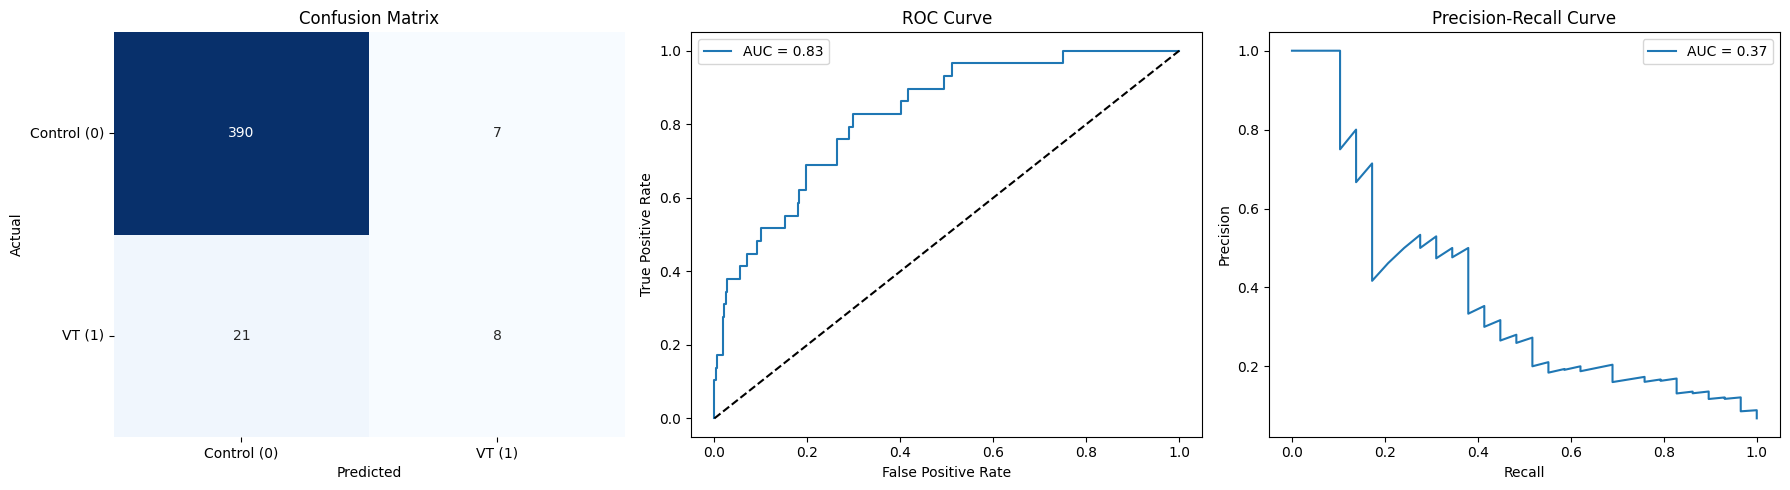

c:\Users\u840716\Anna Thesis\venv310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Evaluation for MLP - KNN Imputation (per class)
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96       397
           1       0.50      0.10      0.17        29

    accuracy                           0.93       426
   macro avg       0.72      0.55      0.57       426
weighted avg       0.91      0.93      0.91       426

F2 Score: 0.1230
Cohen’s Kappa: 0.1516
ROC AUC Score: 0.8568
----------------------------------------


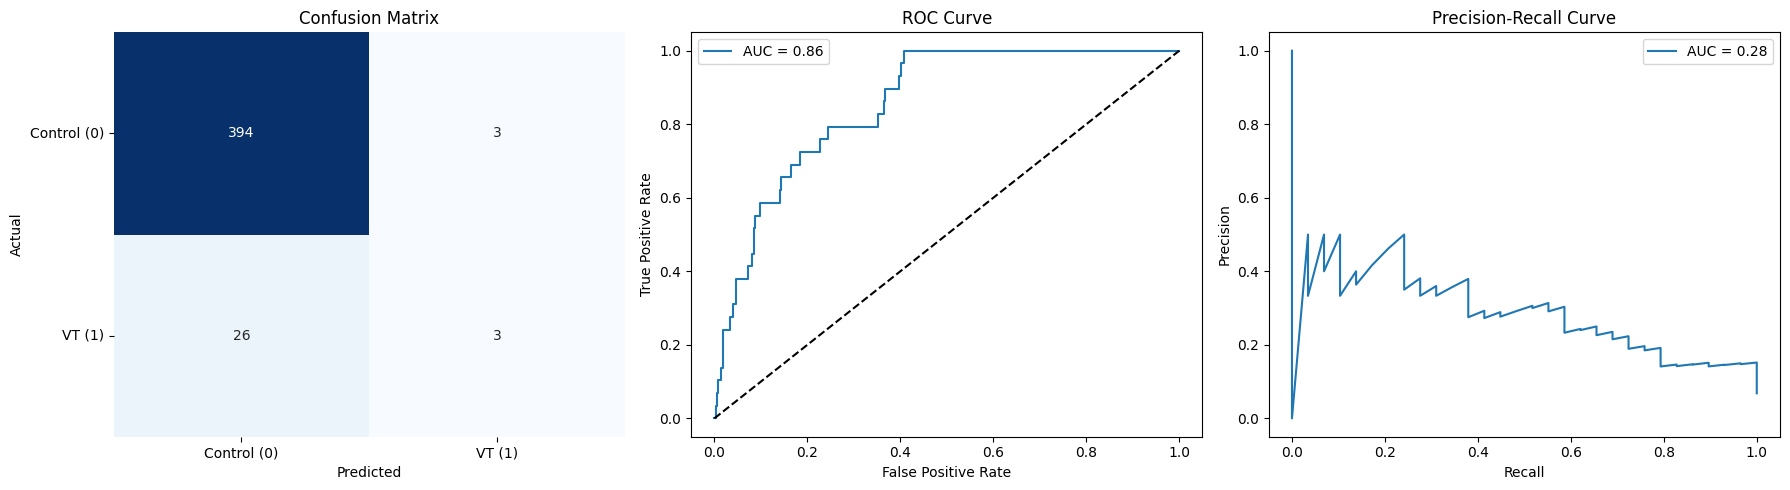

In [25]:
mean_vt = SimpleImputer(strategy='mean')
mean_control = SimpleImputer(strategy='mean')
impute_and_evaluate_mlp(mean_vt, mean_control, "Mean")

median_vt = SimpleImputer(strategy='median')
median_control = SimpleImputer(strategy='median')
impute_and_evaluate_mlp(median_vt, median_control, "Median")

knn_vt = KNNImputer(n_neighbors=5)
knn_control = KNNImputer(n_neighbors=5)
impute_and_evaluate_mlp(knn_vt, knn_control, "KNN")


median performs best

In [27]:
# Impute Train Set
X_vt_train_imputed = pd.DataFrame(median_vt.fit_transform(X_vt_train), columns=X.columns)
X_control_train_imputed = pd.DataFrame(median_control.fit_transform(X_control_train), columns=X.columns)
X_train_median = pd.concat([X_vt_train_imputed, X_control_train_imputed])
y_train_median = pd.concat([y_train[y_train == 1], y_train[y_train == 0]])

# Impute Test Set using train imputers
X_vt_test_imputed = pd.DataFrame(median_vt.transform(X_vt_test), columns=X.columns)
X_control_test_imputed = pd.DataFrame(median_control.transform(X_control_test), columns=X.columns)
X_test_median = pd.concat([X_vt_test_imputed, X_control_test_imputed])
y_test_median = pd.concat([y_test[y_test == 1], y_test[y_test == 0]])

# Shuffle training data
X_train_median, y_train_median = shuffle(X_train_median, y_train_median, random_state=42)

## Oversampling

In [ ]:
# Scaling data 
scaler = StandardScaler().fit(X_train_median)
X_train_scaled = scaler.transform(X_train_median)
X_test_scaled = scaler.transform(X_test_median)

In [ ]:
# Oversampling techniques
adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42)

X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train_median, y_train_median)
X_train_smote, y_train_smote = smote.fit_resample(X_train_median, y_train_median)

c:\Users\u840716\Anna Thesis\venv310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation for MLP - Median Imputation + ADASYN
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       397
           1       0.41      0.41      0.41        29

    accuracy                           0.92       426
   macro avg       0.69      0.69      0.69       426
weighted avg       0.92      0.92      0.92       426

F2 Score: 0.4138
Cohen’s Kappa: 0.3710
ROC AUC Score: 0.8309
----------------------------------------


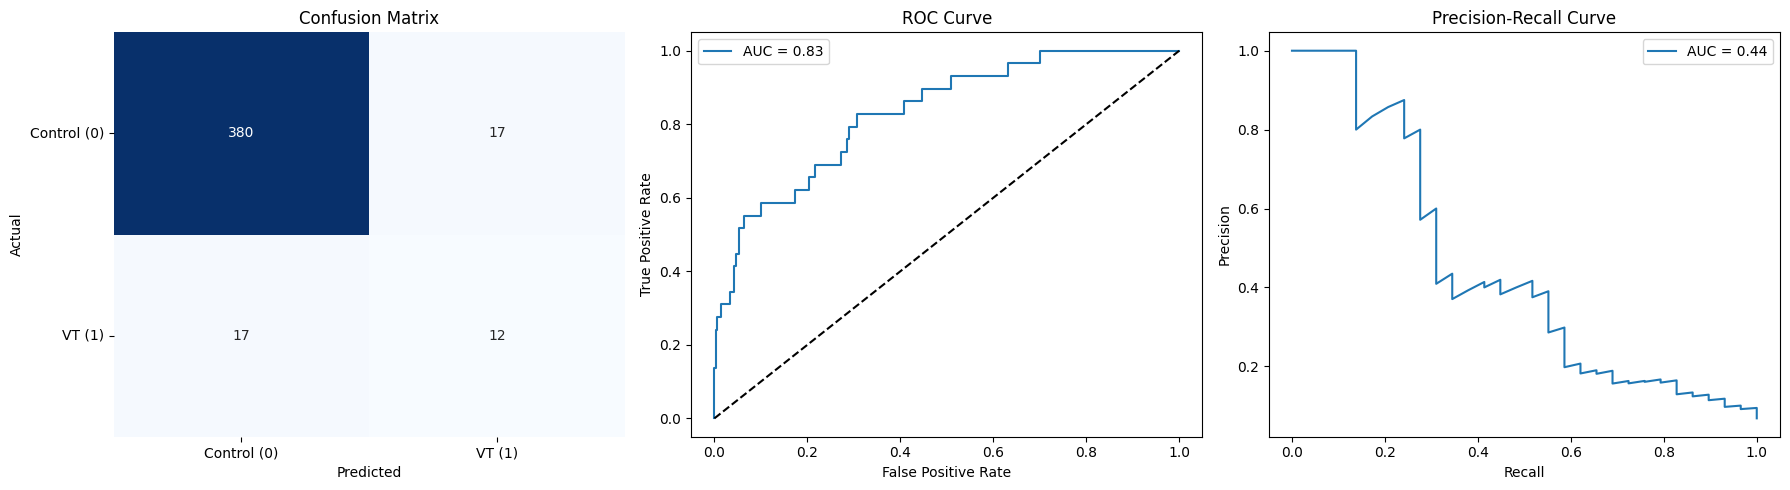

In [ ]:
# Build and train MLP for ADASYN
model_adasyn = build_mlp(X_train_adasyn.shape[1])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_adasyn.fit(
    X_train_adasyn, y_train_adasyn,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=0
)


def wrap_keras_model(model):
    def predict_proba(X_input):
        p1 = model.predict_on_batch(X_input).ravel()
        return np.vstack([1 - p1, p1]).T

    def predict(X_input):
        return (predict_proba(X_input)[:, 1] > 0.5).astype(int)

    model.predict_proba = predict_proba
    model.predict = predict    

wrap_keras_model(model_adasyn)


evaluate_model(
    model_adasyn,
    X_test_scaled,
    y_test_median,
    model_name="MLP - Median Imputation + ADASYN",
    save_fig=True
)

c:\Users\u840716\Anna Thesis\venv310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Evaluation for MLP - Median Imputation + SMOTE
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       397
           1       0.44      0.48      0.46        29

    accuracy                           0.92       426
   macro avg       0.70      0.72      0.71       426
weighted avg       0.93      0.92      0.92       426

F2 Score: 0.4730
Cohen’s Kappa: 0.4174
ROC AUC Score: 0.7789
----------------------------------------


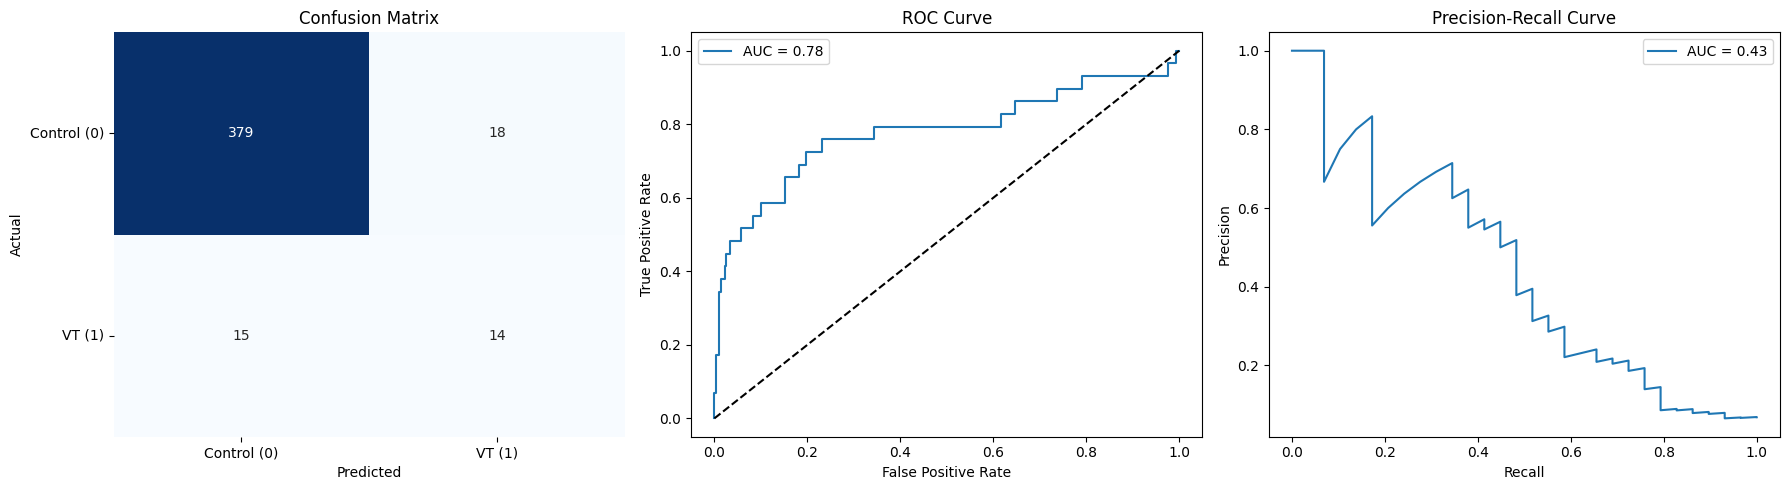

In [ ]:
# Build and train MLP for SMOTE
model_smote = build_mlp(X_train_smote.shape[1])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_smote.fit(
    X_train_smote, y_train_smote,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[es],
    verbose=0
)


def wrap_keras_model(model):
    def predict_proba(X_input):
        p1 = model.predict_on_batch(X_input).ravel()
        return np.vstack([1 - p1, p1]).T

    def predict(X_input):
        return (predict_proba(X_input)[:, 1] > 0.5).astype(int)

    model.predict_proba = predict_proba
    model.predict = predict    

wrap_keras_model(model_smote)


evaluate_model(
    model_smote,
    X_test_scaled,
    y_test_median,
    model_name="MLP - Median Imputation + SMOTE",
    save_fig=True
)

meadian + SMOTE is the best combination

## Hyperparameter Tuning

In [ ]:
# 5‐fold stratified splitter
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)


KerasClassifier.__sklearn_tags__ = lambda self: SimpleNamespace(estimator_type="classifier")

Reloading Tuner from mlp_hp_dir\mlp_tuning\tuner0.json
Epoch 1/100
100/100 - 12s - 120ms/step - auc: 0.9502 - loss: 0.2859
Epoch 2/100
100/100 - 6s - 64ms/step - auc: 0.9952 - loss: 0.0922
Epoch 3/100
100/100 - 4s - 37ms/step - auc: 0.9982 - loss: 0.0556
Epoch 4/100
100/100 - 4s - 36ms/step - auc: 0.9997 - loss: 0.0303
Epoch 5/100
100/100 - 4s - 39ms/step - auc: 0.9996 - loss: 0.0311
Epoch 6/100
100/100 - 4s - 39ms/step - auc: 0.9992 - loss: 0.0277
Epoch 7/100
100/100 - 5s - 51ms/step - auc: 1.0000 - loss: 0.0144
Epoch 8/100
100/100 - 4s - 40ms/step - auc: 0.9999 - loss: 0.0130
Epoch 9/100
100/100 - 4s - 37ms/step - auc: 0.9999 - loss: 0.0162
Epoch 10/100
100/100 - 4s - 42ms/step - auc: 0.9988 - loss: 0.0300
Epoch 11/100
100/100 - 6s - 61ms/step - auc: 0.9988 - loss: 0.0330
Epoch 12/100
100/100 - 4s - 38ms/step - auc: 0.9999 - loss: 0.0138
Epoch 13/100
100/100 - 4s - 43ms/step - auc: 0.9998 - loss: 0.0178
Epoch 14/100
100/100 - 4s - 37ms/step - auc: 0.9999 - loss: 0.0120
Epoch 15/100
1

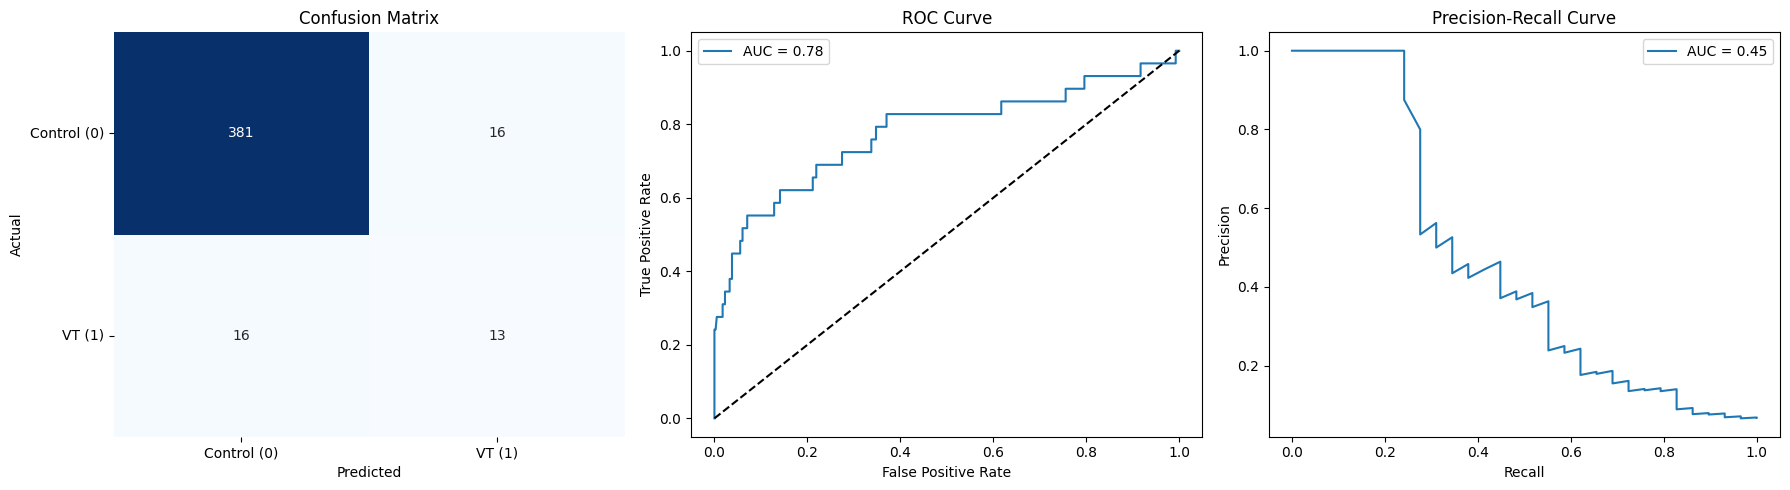

In [ ]:
# Carve off a validation split from training data
X_train_hp, X_val_hp, y_train_hp, y_val_hp = train_test_split(
    X_train_smote, y_train_smote,
    test_size=0.1,
    stratify=y_train_smote,
    random_state=42
)

# Tuner model‐building function
def build_model_hp(hp):
    n_layers = hp.Int('hidden_layers', 1, 3)
    units    = hp.Choice('units', [32, 64, 128])
    dropout  = hp.Float('dropout', 0.1, 0.5, step=0.1)
    lr       = hp.Float('lr', 1e-4, 1e-2, sampling='log')

    inp = Input(shape=(X_train_smote.shape[1],))
    x = inp
    for _ in range(n_layers):
        x = Dense(units, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout)(x)
    out = Dense(1, activation='sigmoid')(x)

    m = Model(inp, out)
    m.compile(
        optimizer=Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return m

# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model_hp,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=15,
    executions_per_trial=1,
    directory='mlp_hp_dir',
    project_name='mlp_tuning'
)

# Early stopping on validation AUC
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', mode='max', patience=5, restore_best_weights=True
)

# Hyperparameter search
tuner.search(
    X_train_hp, y_train_hp,
    validation_data=(X_val_hp, y_val_hp),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2
)

# Build and retrain the best model on all training data
best_hp     = tuner.get_best_hyperparameters(1)[0]
best_model  = build_model_hp(best_hp)
best_model.fit(
    np.vstack([X_train_hp, X_val_hp]),
    np.concatenate([y_train_hp, y_val_hp]),
    epochs=100,
    batch_size=32,
    verbose=2
)

# Monkey‐patch for sklearn‐style API
orig_pred = best_model.predict
def predict_proba(X):
    p1 = orig_pred(X).ravel()
    return np.vstack([1-p1, p1]).T
def predict(X): 
    return (predict_proba(X)[:,1] > 0.5).astype(int)
best_model.predict_proba = predict_proba
best_model.predict       = predict

# Final evaluation on the held‐out test set
evaluate_model(best_model, X_test_scaled, y_test_median, model_name="MLP Tuned_2")

## Imputation Exploration

In [ ]:
# Split by group for group-wise imputation
X_vt = X[y == 1]
X_control = X[y == 0]

# 1. Mean Imputation
mean_imputer = SimpleImputer(strategy="mean")
X_vt_mean = pd.DataFrame(mean_imputer.fit_transform(X_vt), columns=X.columns)
X_control_mean = pd.DataFrame(mean_imputer.fit_transform(X_control), columns=X.columns)
X_mean_imputed = pd.concat([X_vt_mean, X_control_mean])


# 2. Median Imputation
median_imputer = SimpleImputer(strategy="median")
X_vt_median = pd.DataFrame(median_imputer.fit_transform(X_vt), columns=X.columns)
X_control_median = pd.DataFrame(median_imputer.fit_transform(X_control), columns=X.columns)
X_median_imputed = pd.concat([X_vt_median, X_control_median])


# 3. KNN Imputation
knn_imputer = KNNImputer(n_neighbors=2)
X_vt_knn = pd.DataFrame(knn_imputer.fit_transform(X_vt), columns=X.columns)
X_control_knn = pd.DataFrame(knn_imputer.fit_transform(X_control), columns=X.columns)
X_knn_imputed = pd.concat([X_vt_knn, X_control_knn])



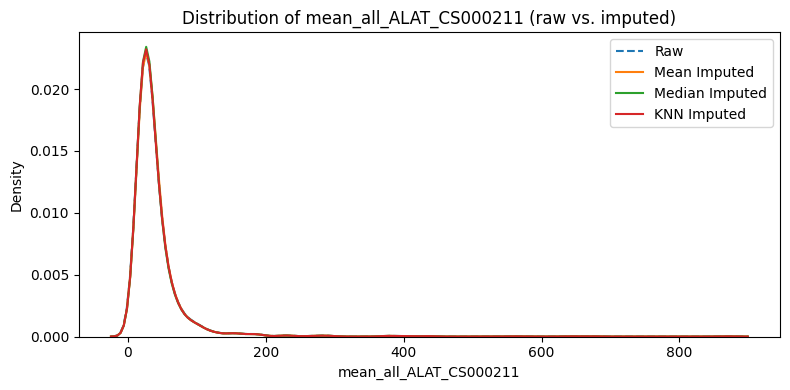

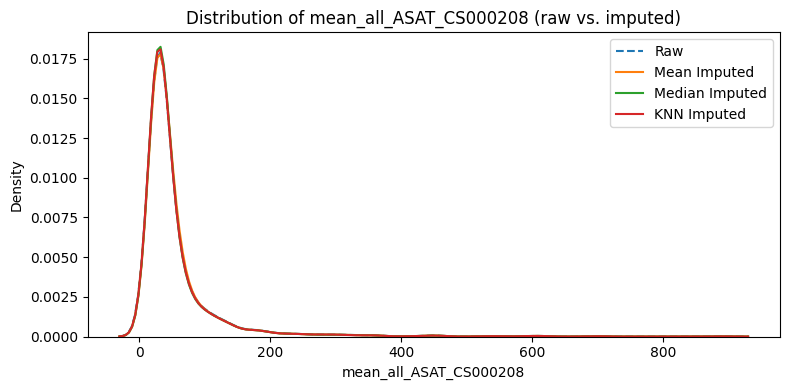

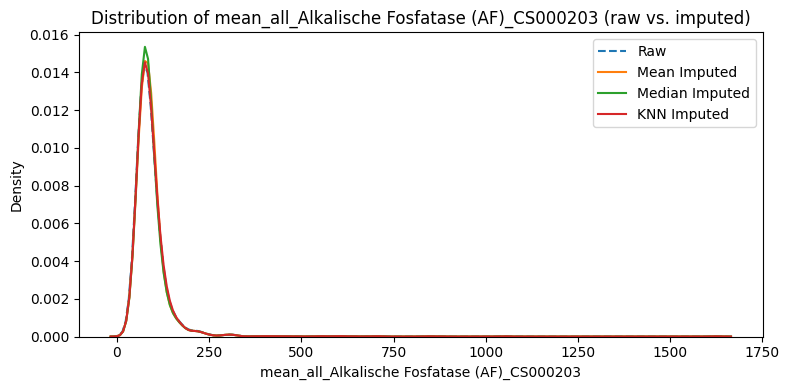

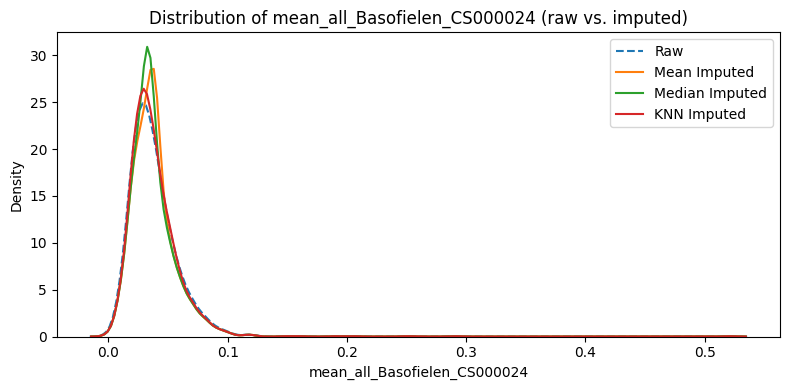

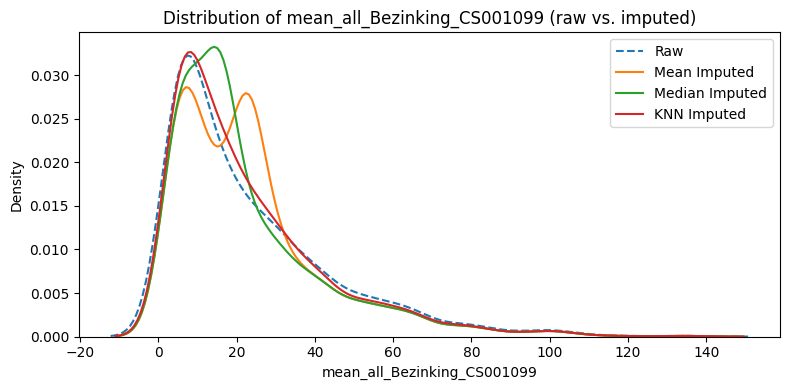

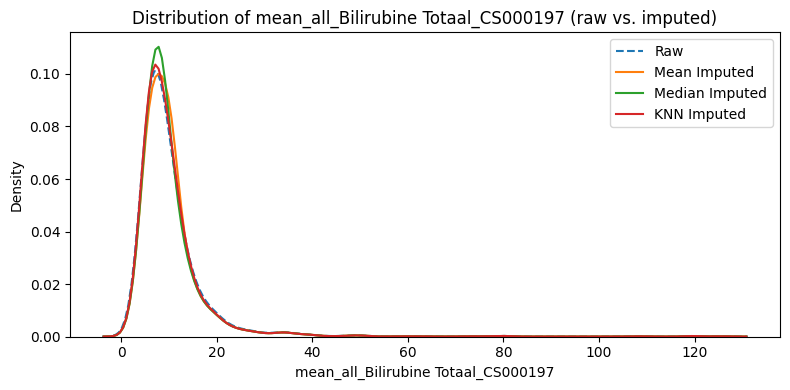

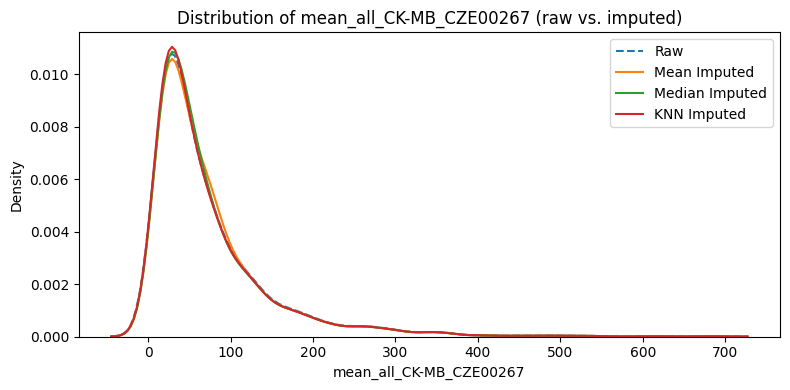

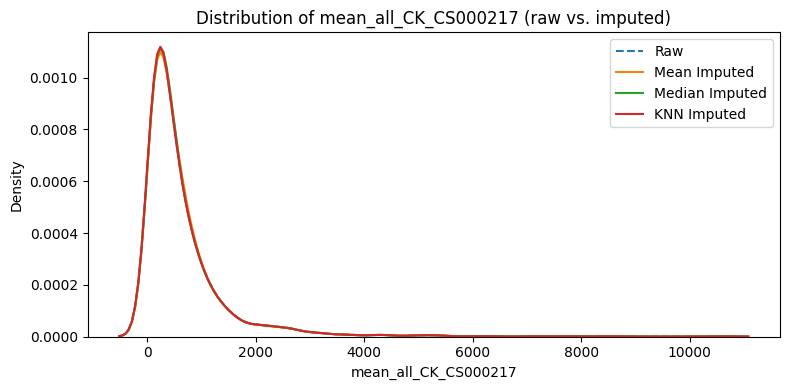

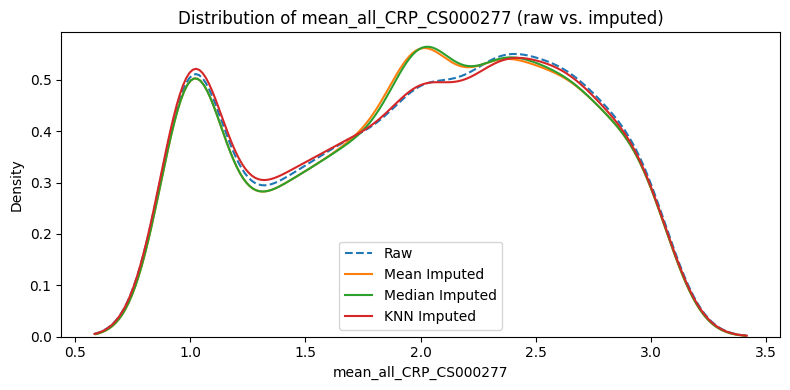

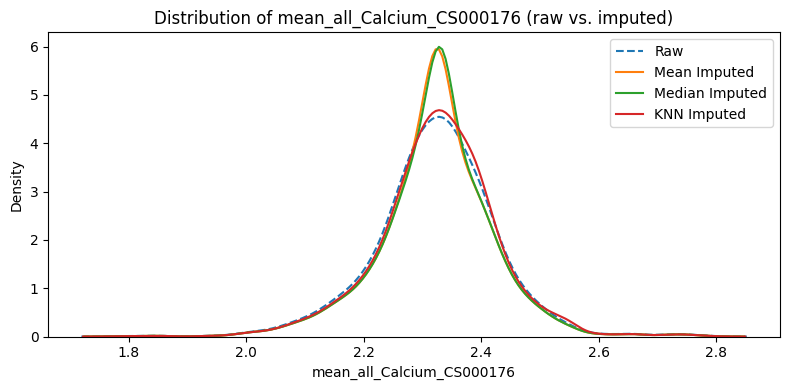

In [ ]:
# Distribution plots for a few representative features
features_to_plot = X.columns[:10]  # top 11

for feat in features_to_plot:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X[feat].dropna(),           label='Raw',            linestyle='--', fill=False)
    sns.kdeplot(X_mean_imputed[feat],       label='Mean Imputed',   fill=False)
    sns.kdeplot(X_median_imputed[feat],     label='Median Imputed', fill=False)
    sns.kdeplot(X_knn_imputed[feat],        label='KNN Imputed',    fill=False)
    plt.title(f'Distribution of {feat} (raw vs. imputed)')
    plt.xlabel(feat)
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()



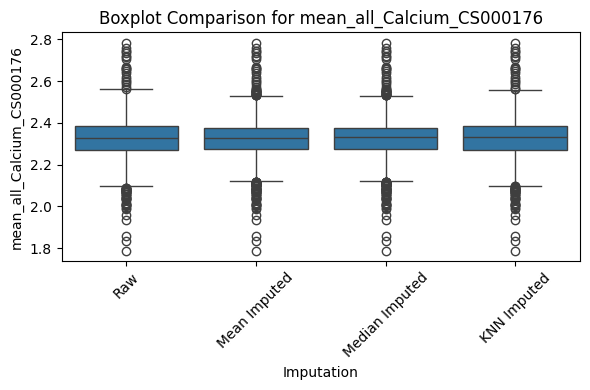

In [12]:
# Boxplot comparison for a specific feature
feat = features_to_plot[9]

# Build a long‐format DataFrame
df_long = pd.concat([
    pd.DataFrame({'Imputation': 'Raw',            'Value': X[feat].dropna().values}),
    pd.DataFrame({'Imputation': 'Mean Imputed',   'Value': X_mean_imputed[feat].values}),
    pd.DataFrame({'Imputation': 'Median Imputed', 'Value': X_median_imputed[feat].values}),
    pd.DataFrame({'Imputation': 'KNN Imputed',    'Value': X_knn_imputed[feat].values}),
], ignore_index=True)

plt.figure(figsize=(6,4))
sns.boxplot(x='Imputation', y='Value', data=df_long)
plt.title(f'Boxplot Comparison for {feat}')
plt.ylabel(feat)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

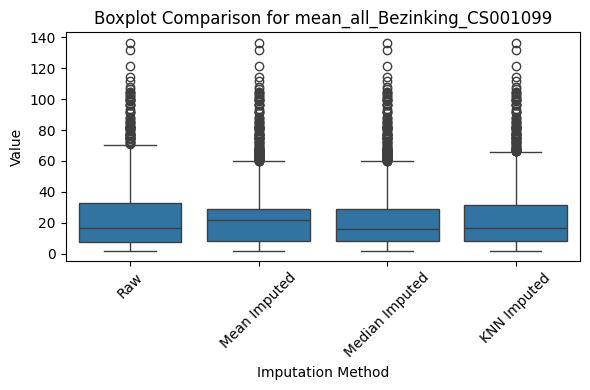

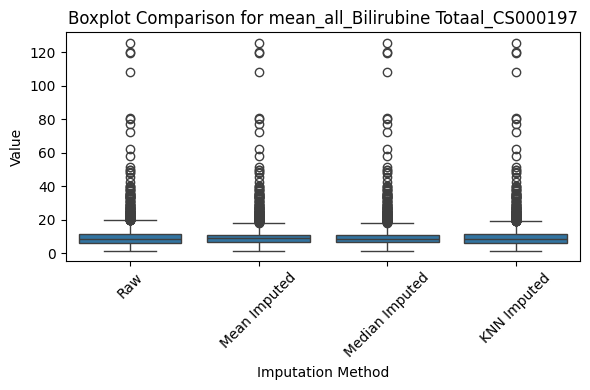

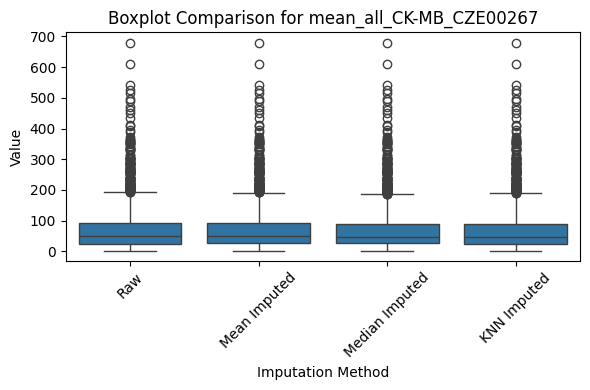

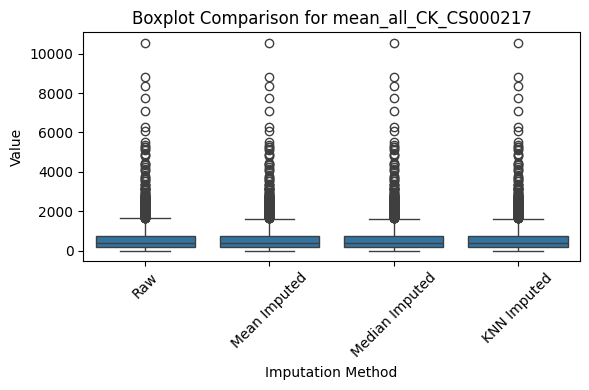

In [ ]:
features_to_plot = X.columns[4:8]

for feat in features_to_plot:
    df_long = pd.concat([
        pd.DataFrame({'Imputation': 'Raw',            'Value': X[feat].dropna().values}),
        pd.DataFrame({'Imputation': 'Mean Imputed',   'Value': X_mean_imputed[feat].values}),
        pd.DataFrame({'Imputation': 'Median Imputed', 'Value': X_median_imputed[feat].values}),
        pd.DataFrame({'Imputation': 'KNN Imputed',    'Value': X_knn_imputed[feat].values}),
    ], ignore_index=True)

  
    plt.figure(figsize=(6,4))
    sns.boxplot(x='Imputation', y='Value', data=df_long)
    plt.title(f'Boxplot Comparison for {feat}')
    plt.ylabel('Value')
    plt.xlabel('Imputation Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

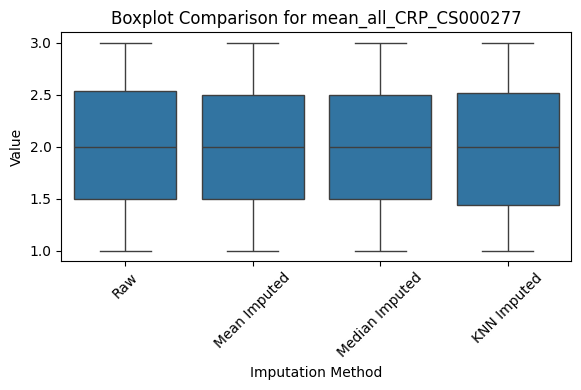

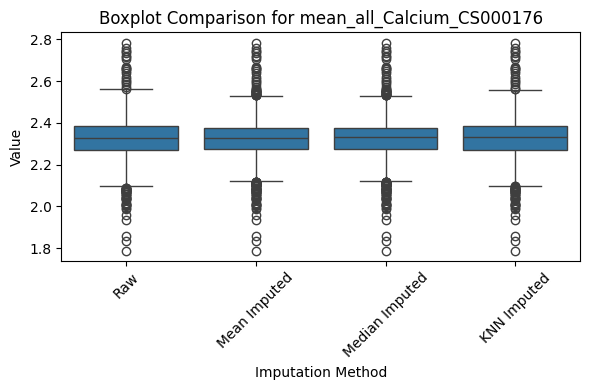

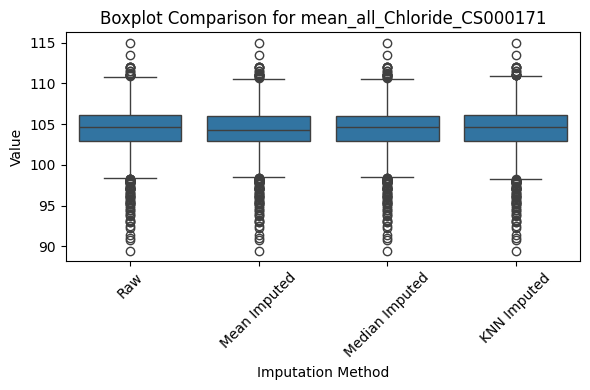

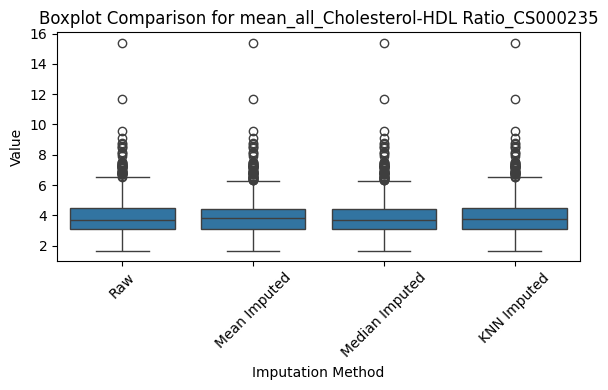

In [ ]:
features_to_plot = X.columns[8:12]

for feat in features_to_plot:
    df_long = pd.concat([
        pd.DataFrame({'Imputation': 'Raw',            'Value': X[feat].dropna().values}),
        pd.DataFrame({'Imputation': 'Mean Imputed',   'Value': X_mean_imputed[feat].values}),
        pd.DataFrame({'Imputation': 'Median Imputed', 'Value': X_median_imputed[feat].values}),
        pd.DataFrame({'Imputation': 'KNN Imputed',    'Value': X_knn_imputed[feat].values}),
    ], ignore_index=True)

    plt.figure(figsize=(6,4))
    sns.boxplot(x='Imputation', y='Value', data=df_long)
    plt.title(f'Boxplot Comparison for {feat}')
    plt.ylabel('Value')
    plt.xlabel('Imputation Method')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()